# 사례를 통해서 배우는 파생 변수 만들기 2편

## 실습 개요

사례를 통해서 배우는 파생 변수 만들기 2편


1) 실습 목적
 * 실제 Kaggle 데이터셋을 통해서 파생 변수를 만들어 보는 실습을 진행합니다.
 * 파생 변수가 만들어지는 과정에서 도메인 지식에 대한 중요성을 파악합니다.
 * 파생 변수 생성 외에도 정형 데이터 해결에 대한 파이프라인을 파악합니다.


2) 수강 목표
 * 모든 정형 데이터 문제에서 도메인에 맞는 파생 변수를 추측할 수 있습니다.
 * 파생 변수가 알고리즘 모델에 미치는 영향을 이해할 수 있습니다.
 * 머신러닝 파이프라인에 존재하는 각 단계가 어떤 역할을 하는지 이해할 수 있습니다.


### 실습 목차

* **1. 캐글 데이터셋 실습 해보기**
  * 캐글 데이터셋 - House Prices
  * 결측치 및 이상치 다루기
  * 파생 변수 만들기


###  데이터셋 개요 </b>

* 데이터셋: USA Housing dataset (Kaggle)
* 데이터셋 개요 : 미국내 부동산 정보 데이터셋
* 데이터셋 저작권 : [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/)

### 환경 설정

- **패키지 설치 및 임포트**
 * 코랩에서는 **scikit-learn** 및 **pandas**가 설치되어 있기 때문에, 따로 패키지를 설치하지 않으셔도 됩니다.

- **Kaggle 데이터셋 다운로드**
    1. Kaggle 회원가입
    2. Account(계정) 페이지 진입 (https://www.kaggle.com/[사옹자이름]/account)
    3. API - Create New API Token 클릭하고 kaggle.json 다운로드
    4. 브라우저에서 json 파일을 열어 username 및 key 복사
    5. 아래 코드에 username과 key 붙여넣기

<center><img src='https://lh3.google.com/u/0/d/1EUspaI24LxPY9KX1EfPXMYGHE4ciIaKc=w1259-h864-iv1' width="600"></center>


In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'myeongwang'
os.environ['KAGGLE_KEY'] = "b2e14da9a966c341ff3cc3aaacfd2fc4"

In [4]:
!kaggle datasets download -d gpandi007/usa-housing-dataset

100%|█████████████████████████████████████████| 179k/179k [00:00<00:00, 794kB/s]
100%|█████████████████████████████████████████| 179k/179k [00:00<00:00, 791kB/s]


In [10]:
!unzip "/Users/myeongjinlee/Desktop/UPSTAGE AI/ml advanced/usa-housing-dataset.zip"

Archive:  /Users/myeongjinlee/Desktop/UPSTAGE AI/ml advanced/usa-housing-dataset.zip
  inflating: housing_test.csv        
  inflating: housing_train.csv       


In [11]:
!pip install scikit-learn==1.2.2
!pip install pandas==1.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 7.4 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully uninstalled scikit-learn-1.3.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 11.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3


In [14]:
# 알고리즘
import xgboost as xgb

from sklearn.neighbors import KNeighborsRegressor

# 계산
import numpy as np

# 전처리
from scipy.special import boxcox1p
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

# 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 출력 및 시각화
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

# 데이터셋 로드 및 정제
import pandas as pd

# 코드 셀 실행 후 경고를 무시
import warnings
warnings.filterwarnings(action='ignore')

## 1. 캐글 데이터셋 실습 해보기

```
💡 목차 개요 : 실제 캐글 데이터셋을 통해 파생 변수를 제작해봅니다.  
```

- **1-1 캐글 데이터셋 - House Prices**
- **1-2 결측치 및 이상치 다루기**
- **1-3 파생 변수 만들기**

### 1-1 캐글 데이터셋 - House Prices

>



#### 📝 설명 : (1-1)
> 드디어 실제 캐글 데이터셋을 만져볼 수 있습니다! 우리가 이번 실습에서 사용하는 데이터셋은 캐글에서 제공하는 [**USA Housing dataset**](https://www.kaggle.com/datasets/gpandi007/usa-housing-dataset) 입니다. 우리가 사전에 수업에서 배웠던 여러 이론들을 적용할 수 있는 고마운 데이터 입니다. 데이터셋을 불러오고 학습하는 하나의 과정을 직접 우리 손으로 해봅시다!

 📖 설명 : 캐글에서 제공하고 있는 USA House Prices은 주택 시장에서 부동산 가격을 예측을 위해 사용되는 유명 데이터셋 입니다. <br>
 주택 가격과 관련된 여러 정보들을 포함하고 있습니다. 이런 정보들은 주택 가격을 예측하거나 분석하는데 중요한 요소로 활용됩니다. <br>
 주요 정보는 아래와 같습니다.
 - 주택&부지 면적
 - 지역
 - 침실 수
 - 차고 유무
 - 주택 유형
 - 건축 연도
 - 판매 가격 (예측할 값)


<img src='https://lh3.google.com/u/0/d/1GAJDayRhz8zXD-5mXO4prBepqGb7YqR0=w1259-h864-iv1' width="1000">

#### 👨‍💻 코드 : (1-1)


- 캐글에서는 다양한 방법으로 데이터셋을 제공합니다.
- 우리가 실습할 데이터는 다행히도 학습(train.csv) 및 테스트(test.csv) 데이터로 각각 나뉘어 있습니다.
- 데이터가 나뉘어 있는 이유는 학습 데이터셋으로 모델을 학습한 후, 테스트 데이터셋으로 모델의 성능을 검증하는 용도입니다.
- 이런 경우는 손쉽게 데이터를 바로 이용할 수 있지만, 이와 반대로 학습 및 검증 그리고 테스트 데이터를 직접 나눠야 하는 경우도 있습니다.

In [15]:
# 학습 및 테스트 데이터셋을 로드합시다.
train_df = pd.read_csv("housing_train.csv")
test_df = pd.read_csv("housing_test.csv")

display("Train Dataset")
display(train_df)

display("Test Dataset")
display(test_df)

'Train Dataset'

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


'Test Dataset'

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


- 학습 및 테스트 데이터의 열(Row) 수가 비슷한 것이 특징입니다.
- 주택 가격을 예측하는 문제이니 테스트 데이터에는 SalePrice 컬럼이 결측인 것을 볼 수 있습니다.
- 엄청나게 많은 컬럼(80개)들이 보입니다.
- 72번 컬럼(PoolQC)처럼 많은 결측값(7 non-null)의 존재도 확인할 수 있습니다.

In [16]:
# 컬럼 정보를 대충 훑어 봅시다.
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

None

- 앞서 대회 및 실무에서는 도메인 지식이 매우 중요하다고 말씀드렸습니다.
- 캐글에서는 제공하는 컬럼 정보를 보고 **도메인 지식에 알맞는 파생 변수를 만들어 내는 것도 중요**합니다.
- 주택 가격과 관련된 여러 정보들이 존재하는 것을 보실 수 있습니다.
- 한번 훑어보고 정보를 파악해 보도록 합시다.

#### 📚 자료 : (1-1)

*  [USA Housing dataset](https://www.kaggle.com/datasets/gpandi007/usa-housing-dataset) : 실습 데이터를 제공하는 캐글 페이지
*  [부동산 및 건축 용어집](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=mirrnk1&logNo=221262839065) : 도메인 지식 향상


### 1-2 결측치 및 이상치 다루기

> 파생 변수를 제작하는 것도 중요하지만, 결측치 및 이상치를 탐지하고 제거하는 것이 선행되어야 합니다.<br>
결측치와 이상치에 대해 알아보고 직접 데이터셋에서 찾아보도록 합시다. <br>




#### 📝 설명 : (1-2)
> 실무 및 대회 데이터를 다룰 때 대부분 결측치와 이상치를 마주하게 됩니다. <br>
> 결측치 및 이상치를 처리하는 것은 데이터 전처리에서 필수 단계입니다. <br>
> 이번 실습에서는 데이터셋에 존재하는 결측치와 이상치를 직접 다뤄보도록 하겠습니다. <br>


#### 👨‍💻 코드 : (1-2)


- **결측치를 처리**해봅시다.

In [17]:
# 전처리에 앞서, 학습데이터와 테스트를 합쳐 전처리를 진행합시다.
df = pd.concat([train_df, test_df], axis=0)

# 추후 사용을 위해 필요한 정보는 다른 변수에 저장합니다.
y_train = train_df["SalePrice"]

train_size = len(train_df)
test_size = len(test_df)

# 불필요한 컬럼은 필요 없으니 제거해줍니다.
df.drop(columns=["Id", "SalePrice"], inplace=True)

In [18]:
# 범주형 변수와 수치형 변수로 나눠서 결측치를 처리해봅시다.
missing_cat_cols = df.loc[:, df.isna().sum() > 0].select_dtypes("object").columns
missing_num_cols = df.loc[:, df.isna().sum() > 0].select_dtypes(np.number).columns

display("범주형 변수 결측치 현황")
display(df.loc[:, missing_cat_cols].isna().sum())

'범주형 변수 결측치 현황'

MSZoning           4
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

In [19]:
display("수치형 변수 결측치 현황")
display(df.loc[:, missing_num_cols].isna().sum())

'수치형 변수 결측치 현황'

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

In [20]:
# Series 타입 데이터를 데이터프레임으로 전환
missing_cat_df = pd.DataFrame(df.loc[:, missing_cat_cols].isna().sum())
missing_num_df = pd.DataFrame(df.loc[:, missing_num_cols].isna().sum())

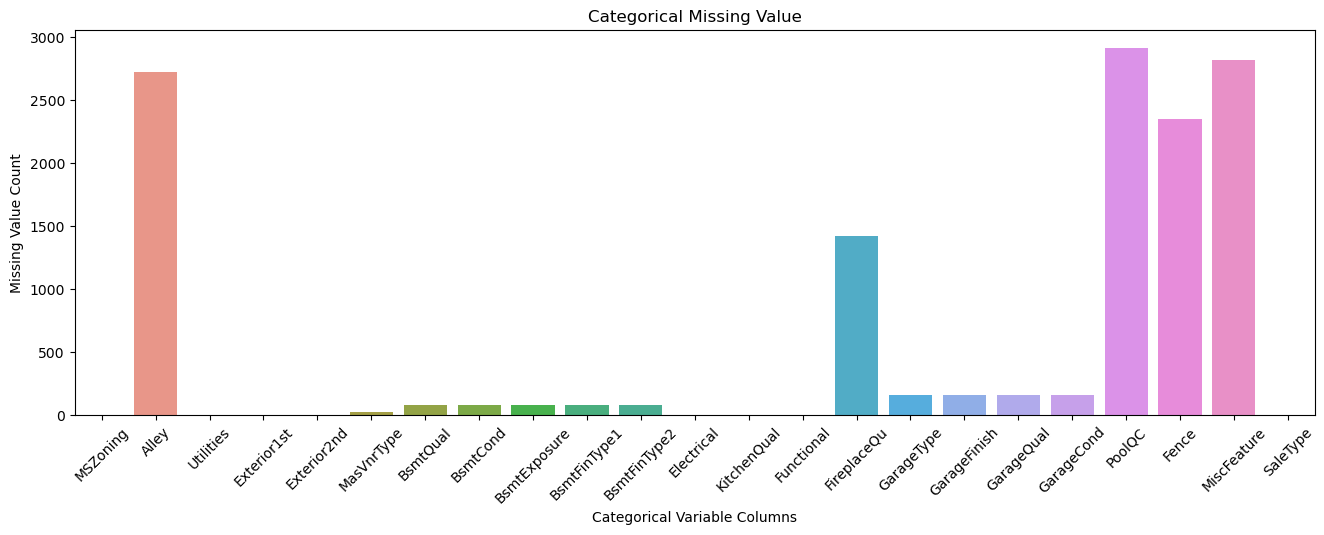

In [21]:
# 범주형 변수의 결측치 시각화

# 차트 크기 설정
plt.figure(figsize=(16, 5))
# 막대(Bar) 차트 생성
sns.barplot(data=missing_cat_df, x=missing_cat_df.index, y=missing_cat_df[0])
# 차트 제목
plt.title("Categorical Missing Value")
# X,Y축 레이블 설정
plt.xlabel("Categorical Variable Columns")
plt.ylabel("Missing Value Count")
plt.xticks(rotation=45)

plt.show()

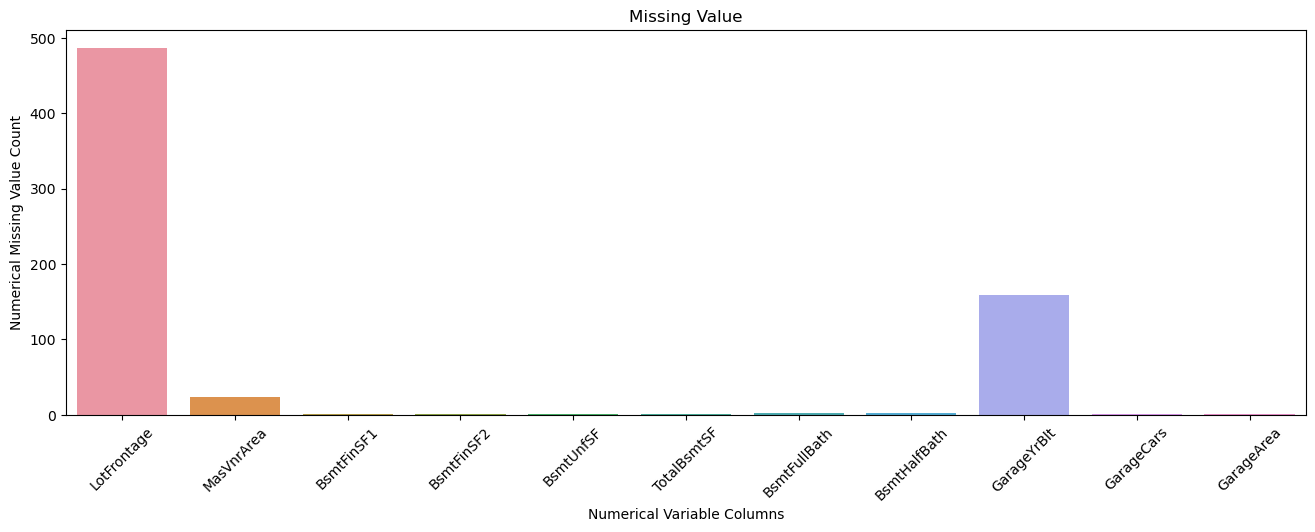

In [22]:
# 연속형 변수의 결측치 시각화
plt.figure(figsize=(16, 5))
sns.barplot(data=missing_num_df, x=missing_num_df.index, y=missing_num_df[0])
plt.title("Missing Value")
plt.xlabel("Numerical Variable Columns")
plt.ylabel("Numerical Missing Value Count")
plt.xticks(rotation=45)
plt.show()

- **결측치 및 이상치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.**
- 우선 **결측치를 삭제(Listwise)** 해보도록 하겠습니다.
- 결측치를 삭제하는 데 있어서 항상 주의해야 합니다. 결측치도 중요한 정보를 지닐 수 있기 때문입니다.
- 본 실습에서는 위의 막대 차트에서 PoolQC(주택 수영장의 퀄리티) 컬럼을 제거하도록 하겠습니다.

<center><img src='https://lh3.google.com/u/0/d/1gt8mrlbeh154XCViowbhI4L1RZkS4vOi=w1259-h864-iv1' width="800"></center>

<center><em>이미지) 결측치가 포함된 "등락률" 컬럼을 제거</em></center>

In [23]:
# drop()은 컬럼을 제거하는 기능입니다.
df.drop(columns=["PoolQC"], inplace=True)

- 이번엔 **결측치 대체(Imputation)**를 해보겠습니다.
- 최빈값 대체는 효율적이면서 간단한 방법입니다.
- 비교적 결측 비율이 낮은 변수들은 최빈값으로 채워놓도록 하겠습니다.
- mode()는 최빈값을 구하는 함수입니다.
- 아래 그림은 통계치 대체의 예제입니다.

<center><img src='https://lh3.google.com/u/0/d/1hv4-bTo1SVx69N5mIW_-KyN2lgr4W_tH=w1259-h864-iv1' width="800"></center>

<center><em> 이미지) 결측이 발생한 "시가"를 평균값으로 대체</em></center>

In [24]:
# 최빈값으로 대체할 컬럼들을 선정합시다.
mode_cols = [
    "MSZoning", "GarageYrBlt", "GarageCars", "GarageArea",
    "Utilities", "Exterior1st", "Exterior2nd",
    "MasVnrType", "Electrical", "KitchenQual",
    "Functional", "SaleType"
    ]

# 반복문과 fillna를 이용하면 손쉽게 변환이 가능합니다.
for col in mode_cols:
    df[col] = df[col].fillna(df[col].mode()[0])#mode 최빈값

- 특정 값을 채워서 결측치를 대체하는 방법도 있습니다.
- 결측이 많은 경우에는 특정값을 채워 넣어 결측이 일어나지 않은 관측치를 돋보이게 변경할 수 있습니다.
- 아무 특정값이나 넣어도되니 저는 "Nothing"으로 채워 넣도록 하겠습니다.

In [25]:
# 위와 마찬가지로 결측치를 특정값으로 대체할 컬럼들을 선정합니다.
fill_cols = [
    "Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual",
    "GarageCond", "Fence", "MiscFeature"
]

for col in fill_cols:
    df[col] = df[col].fillna("Nothing")

- 수치형 변수에 대한 결측값을 처리해보도록 합시다.
- 이번에는 두가지 방법으로 나눠서 접근합니다.
- 첫번째는 통계치 대체입니다. 앞선 최빈값외에도 **평균값 대체**를 해보도록 하겠습니다.

In [26]:
# 주차장까지의 직선거리를 평균값으로 대체해 봅시다.
df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].mean())

- 두번째는 **회귀 대체**입니다. KNN 알고리즘을 이용해 결측값을 예측해보도록 하겠습니다.
- KNN은 데이터 포인트 간의 거리를 유클리드 및 맨하튼 방법으로 측정하여 분류 및 예측하는 알고리즘 입니다.

<center><img src='https://lh3.google.com/u/0/d/19MMooKu8IHy8lvyjfQW3_f-QaSo2n7dp=w1259-h864-iv1' width="800"></center>

<center><em> 이미지) 결측이 발생한 변수들의 관측치를 예측</em></center>
<br>

---

<center><img src='https://lh3.google.com/u/0/d/1aD-cJQBxmxIzgc5RXUJgVU22vzEN5lvu=w1259-h864-iv1' width="500"></center>

<center><em> 이미지) KNN 알고리즘</em></center>

In [27]:
# KNN으로 결측치를 채워놓을 변수 리스트입니다.
knn_cols = [
    "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"
    ]

# 반복문으로 각 컬럼마다 학습 후, 예측을 해봅시다.
for col in knn_cols:
    # KNN 회귀관련 인스턴스를 불러옵니다.
    knn = KNeighborsRegressor(n_neighbors=10)

    # 수치형 변수를 선택합니다.
    numerical = df.select_dtypes(np.number)
    # 결측값이 존재하지 않는 변수들을 선택합니다.
    non_na_num_cols = numerical.loc[:, numerical.isna().sum() == 0].columns

    # 결측치가 발생한 컬럼을 y, 관측치가 존재하는 컬럼을 X로 구성합니다.
    X = numerical.loc[numerical[col].isna() == False, non_na_num_cols]
    y = numerical.loc[numerical[col].isna() == False, col]

    X_test = numerical.loc[numerical[col].isna() == True, non_na_num_cols]

    # knn을 학습 합니다.
    knn.fit(X, y)

    # 결측치를 예측합니다.
    y_pred = knn.predict(X_test)

    # 결측치를 예측된 값으로 채워 놓습니다.
    df.loc[numerical[col].isna() == True, col] = y_pred

- 이번엔 **이상치를 처리**해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다.
- 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 차고 제작연도(GarageYrBlt) 관련해서 describe()로 살펴보도록 하겠습니다.

count    2919.000000
mean     1979.577938
std        25.605659
min      1895.000000
25%      1961.500000
50%      1984.000000
75%      2003.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64

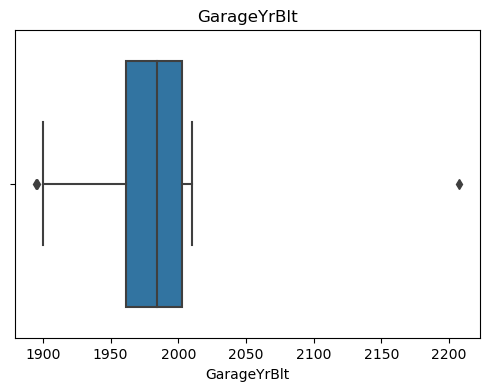

In [28]:
# 차고 제작연도(GarageYrBlt) 기본 통계치 출력
display(df["GarageYrBlt"].describe())

plt.figure(figsize=(6, 4))
sns.boxplot(x=df["GarageYrBlt"])
plt.title(f"GarageYrBlt")
plt.show()

- 뭔가 이상하게 느껴지나요?
- 연도임에도 불구하고 max 값이 2207로 비정상적입니다.
- 해당 데이터셋이 캐글에 만들어진 2018년을 기준으로 이상치를 찾아보겠습니다.

In [29]:
# 2018보다 큰 값을 가지는 행(Row) 출력
display(df[df["GarageYrBlt"] > 2018])

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1132,20,RL,68.0,8298,Pave,Nothing,IR1,HLS,AllPub,Inside,...,0,0,0,Nothing,Nothing,0,9,2007,New,Partial


- **이상치를 대체(Imputation)**를 직접 실습합시다.
- 이상치는 전산 오류, 오탈자, 초자연적인 현상, 의도적 이상치 생성 등으로 발생하게 됩니다.
- 이번 2077이라는 이상치는 2007에 대한 오탈자로 보고 대체하겠습니다.

In [30]:
# 이상치 대체 2207 -> 2007
df.loc[df['GarageYrBlt'] == 2207, 'GarageYrBlt'] = 2007

#### 📚 자료 : (1-2)
*  [Working with missing data](https://pandas.pydata.org/docs/user_guide/missing_data.html) : 결측치 자료
*  [Detecting and Handling Outliers with Pandas](https://hersanyagci.medium.com/detecting-and-handling-outliers-with-pandas-7adbfcd5cad8) : 이상치 자료1
*  [Handling Outliers in Pandas](https://medium.com/@arsalan_zafar/handling-outliers-in-pandas-5cd872eef508) : 이상치 자료2
*  [House Price Competition top 5%, Scoring 0.12035](https://medium.com/@arsalan_zafar/handling-outliers-in-pandas-5cd872eef508) : 참고용 Kaggle 노트북


### 1-3 파생 변수 만들기

> 사실 파생 변수는 많은 반복을 통해서 만들어지게 됩니다. <br> 기존의 데이터셋을 충분히 이해했어도 모델 입장에서 패턴을 발견하지 못한다면, 성능을 떨어뜨리는 결과를 낳게 됩니다. <br> 이를 주의 하면서 실습을 시작합시다. <br>





#### 📝 설명 : (1-3)
> 크게 두 가지 갈래로 파생 변수를 생성해보도록 하겠습니다. <br>
- **변수 간의 관계를 통해 파생 변수를 제작**
    - 부대 시설 유무
    - 연면적 (Total Square) 계산
- **변수 자체를 파생 변수로 전환**
    - 로그 변환
    - min-max scaling

#### 👨‍💻 코드 : (1-3)

- **파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.**
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.
---


- 주택 가격에 영향을 미치는 요소중에 하나는 부대시설입니다.
- 물론 한국은 대부분 공동주택의 수요가 많기 때문에 부대시설이 어느정도 공통되어 있습니다.
- 하지만, 미국을 비롯한 단독주택이 활성화 되어 있는 나라에서는 차고, 수영장 등의 부대시설 여부가 주택 가격에 영향을 주기도 합니다.
- **첫번째로 부대시설 여부를 파생 변수로 제작해 봅시다.**

<center><img src='https://lh3.google.com/u/0/d/1Ew6XKcZMEVzQWZhL8JwAzd6Lc3ETC9Ag=w1920-h864-iv1' width="500"></center>

<center><em> 이미지) 수영장과 같은 부대시설의 여부</em></center>

In [31]:
# 관측치가 1이상이면 부대시설이 존재한다고 가정합니다.
# lambda를 이용하면 모든 열에 조건문을 적용할 수 있습니다.
df["hasPool"] = df["PoolArea"].apply(lambda x: 1 if x > 0 else 0)
df["has2ndFloor"] = df["2ndFlrSF"].apply(lambda x: 1 if x > 0 else 0)
df["hasGarage"] = df["GarageArea"].apply(lambda x: 1 if x > 0 else 0)
df["hasBsmt"] = df["TotalBsmtSF"].apply(lambda x: 1 if x > 0 else 0)
df["hasFirePlace"] = df["Fireplaces"].apply(lambda x: 1 if x > 0 else 0)

In [32]:
# 새로 만들어진 파생 변수를 확인해볼까요?
df[["hasPool", "has2ndFloor", "hasGarage", "hasBsmt", "hasFirePlace"]]

,hasPool,has2ndFloor,hasGarage,hasBsmt,hasFirePlace
0,0,1,1,1,0
1,0,0,1,1,1
2,0,1,1,1,1
3,0,1,1,1,1
4,0,1,1,1,1
...,...,...,...,...,...
1454,0,1,0,1,0
1455,0,1,1,1,0
1456,0,0,1,1,1
1457,0,0,0,1,0


- 데크(WoodDeckSF), 개방형 현관(OpenPorchSF) 등의 또 다른 부대시설 여부 파생 변수도 만들어볼까요?
- 그리고 욕실이 총 몇개 존재하는지도 판단하는 파생 변수를 만들겠습니다.

<center><img src='https://lh3.google.com/u/0/d/1GTnR0C6e_xE9U4dvLddeNGZTZbZ03nJm=w1920-h864-iv1' width="600"></center>

<center><em> 이미지) 우드 데크</em></center>

In [33]:
df["hasWoodDeck"] = df["WoodDeckSF"].apply(lambda x: 1 if x > 0 else 0)
df["hasOpenPorch"] = df["OpenPorchSF"].apply(lambda x: 1 if x > 0 else 0)
df["hasEnclosedPorch"] = df["EnclosedPorch"].apply(lambda x: 1 if x > 0 else 0)
df["has3SsnPorch"] = df["3SsnPorch"].apply(lambda x: 1 if x > 0 else 0)
df["hasScreenPorch"] = df["ScreenPorch"].apply(lambda x: 1 if x > 0 else 0)

- 단독주택이나 공동주택에 살면서 리모델링을 해본 경험이 있으신가요?
- 리모델링은 주택 골조나 공조 시스템(HVAC)과 같은 기본이 되는 요소들은 유지하면서 바닥자재, 벽지, 타일 등을 새롭게 재구성하는 것을 의미합니다.
- 동일한 주택이라도 리모델링을 한 주택들은 실제로 그렇지 못한 주택에 비해 훨씬 비싼 값에 거래되곤 합니다.
- 주택 완공 연도(YearBuilt)와 리모델링 연도(YearRemodAdd)의 차이를 파생 변수로 만들어 보겠습니다.

<center><img src='https://lh3.google.com/u/0/d/1yv989HdEUWV6nw5bRgY-BMQv3YDCsRQQ=w1259-h864-iv1' width="600"></center>

<center><em> 이미지) 리모델링</em></center>

In [34]:
df['RemodAfterBuilt'] = df['YearRemodAdd'] - df['YearBuilt']
# 현재시점 - df['YearRemodAdd']
# clip을 사용하면 하향 임계값(lower bound)를 설정해줄 수 있습니다.
df['RemodAfterBuilt'] = df['RemodAfterBuilt'].clip(lower=0)

- **두 번째 파생 변수는 연면적입니다.**
- 주택에서 연면적은 매우 중요한 수치입니다.
- 연면적은 주택의 모든 바닥 면적을 합산한 결과입니다.
- 아래 그림처럼 지상 2층, 지하 1층으로 구성된 주택에서 모든 바닥 면적을 합치면 연면적이 됩니다.
- 다만, 한국의 공동주택(아파트)에서는 건물 연면적보다는 전용, 공용, 공급면적이 많이 쓰입니다.

<center><img src='https://lh3.google.com/u/0/d/1-dkNxUu_h23-wL5FY4Qm8BRWLhvJepEi=w1259-h864-iv1' width="1000"></center>

<center><em> 이미지) 연면적 계산</em></center>

In [35]:
# 연면적 계산
df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]

# 비슷한 개념으로 총 화장실 개수 계산합시다.
df["TotalBathRooms"] = df['FullBath'] + df['HalfBath'] + df['BsmtFullBath'] + df['BsmtHalfBath']

- 마지막 세번째로 **변수 자체를 파생 변수로 전환** 해봅시다.
- 우선 우리가 예측하려는 SalePrice의 히스토그램을 그려보죠.

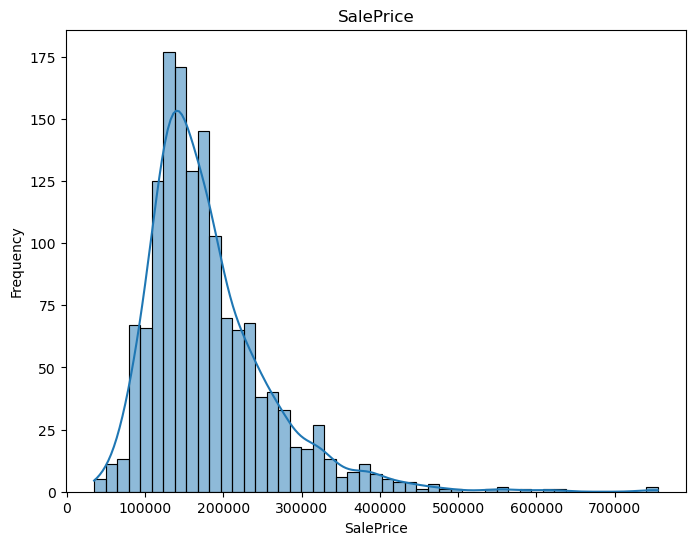

In [36]:
plt.figure(figsize=(8, 6))
sns.histplot(data=y_train, kde=True)
plt.title(f"SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

- 왼쪽으로 치우쳐져 있는 것을 볼수 있습니다.
- **로그 변환** 적용해 정규분포를 띄도록 바꿔보도록하겠습니다.

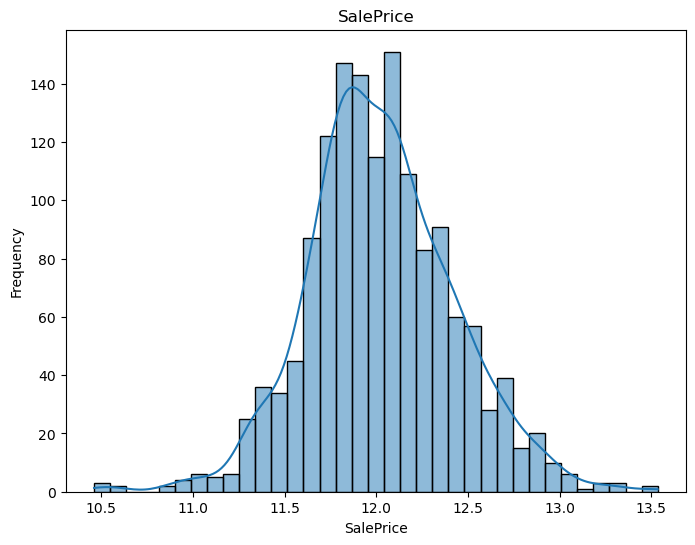

In [37]:
# 데이터에 0값이 존재할 수 있으니 log1p를 사용합니다.
y_train = np.log1p(y_train)

plt.figure(figsize=(8, 6))
sns.histplot(data=y_train, kde=True)
plt.title(f"SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

- 마지막으로 **수치형 변수에는 min-max scaling을 적용하고 범주형 변수에는 label encoding**을 적용해보겠습니다.


In [38]:
# 수치형 변수를 min-max scaling을 해줍시다.
for col in df.select_dtypes(np.number).columns:
    df[col] = MinMaxScaler().fit_transform(df[[col]])

In [39]:
# 범주형 변수를 label encoding을 해줍시다.
for col in df.select_dtypes("object").columns:
    df[col] = LabelEncoder().fit_transform(df[col])

#### 📚 자료 : (1-3)
*  [Advanced Regression for House Prices](https://www.kaggle.com/code/aideesis/advanced-regression-for-house-prices) : 참고용 Kaggle 노트북
